# 시계열 예측

- 시계열 값의 미래 예측 (time series forecasting)
 - 수요예측, 매출예측, 생산/물류/재고 예측, 리스크/장애/이상 예측 등

## 접근법
- (1) 자신의 과거 값만 사용하여 미래 값을 예측하는 (y-y 모델)
 - 선형예측, ARIMA, Prophet 등 수리 모델 기반의 단변수 예측 모델이 널리 사용되었다
 - 랜덤 포레스트 등 머신러닝 모델을 사용할 수 있다
 - 신호의 패턴에 따라 성능에 한계가 있다
 - 랜덤한 성분은 예측이 안된다 (트렌드, 주기성 만 예측 가능)
- (2) 다양한 관련 외부 특성들을 보고 예측하는 (X-y 모델)
 - y에 영향을 주는 다양한 환경 변수들을 입력 특성 X에 포함한다
 - X에 y의 과거 값들도 포함시킬 수 있다 (위의 1을 포함하는 셈!)
 - 입력 X에 변형된 특성을 추가할 수 있다 (이동 평균, 이동 분산 등)
 - 카테고리 변수들이 많으면 X-y 모델이 편리하다 (선형계열 모델은 카테고리 변수를 표현하는데 한계가 있다)
 - 랜덤 포레스트를 주로 사용한다
- (3) 샘플(행) 단위의 예측이 아니라 입력신호의 누적 효과를 반영하는 (신경망 모델)
 - LSTM을 주로 사용한다
 - 좋은 성능을 얻으려면 학습 데이터가 충분히 많아야 한다

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

## 단변수 시계열 예측

- 선형 회귀 (linear regression) 모델: 자신의 과거 샘플의 가중합으로 미래를 예측하는 모델


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$

 - ARIMA 모델: 선형 모델을 개선하여, 계절성, 트렌드, 시변성 등을 반영한 모델
  - 결측치가 없어야 한다 (계산 오류 발생)
 - 단변수 시계열 예측 도구로 Prophet이 편리하다 (결측치 자동처리, 이벤트 반영 등)
 - 단순히 과거의 평균치를 사용하는 baseline 모델도 사용된다
 - 랜덤 포레스트, 부스팅 등 머신러닝 모델도 사용된다

# 기온 예측
## import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 15})

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score

## 날씨 데이터

In [4]:
weather = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/new_weather.csv')
print(weather.shape)
weather[:3]

(4018, 4)


,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


- 단변수 시계열
 - 날짜 정보를 사용하지 않고 단순히 숫자의 나열로 데이터가 주어지는 경우

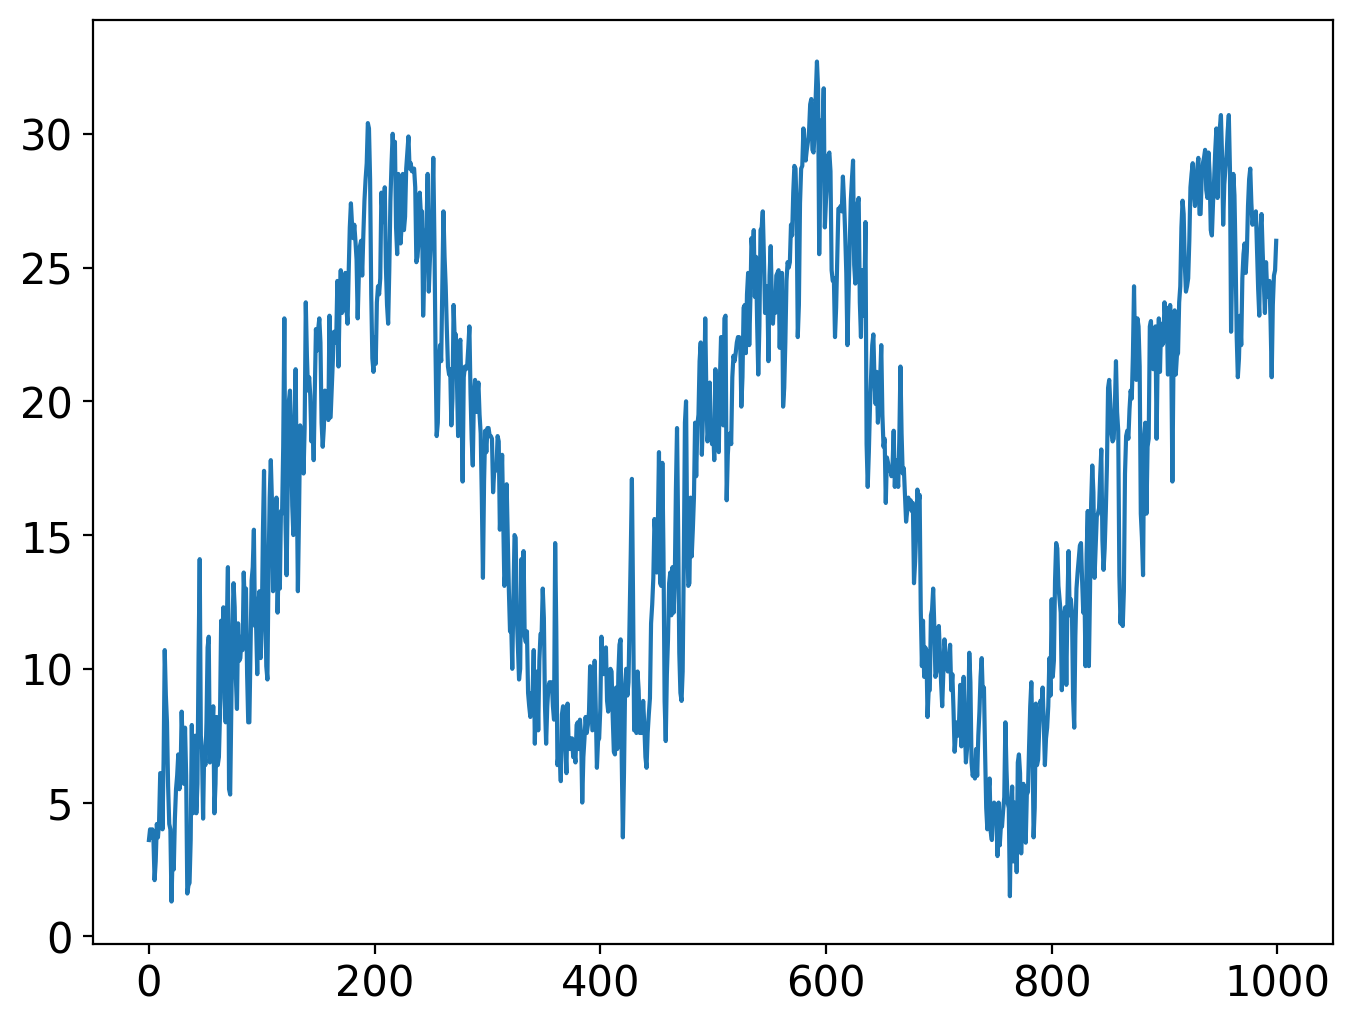

In [7]:
y = weather["기온"].values
plt.plot(y[:1000])

In [8]:
y[:20]

array([ 3.6,  4. ,  3.7,  4. ,  3.6,  2.1,  2.8,  4.2,  3.7,  4.3,  6.1,
        6.1,  4. ,  6.6, 10.7,  9. ,  8. ,  5.6,  4.2,  4. ])

## 훈련, 검증 데이터 나누기
- 시계열 데이터는 순서를 유지해야 의미가 있으므로 랜덤하게 섞으면 안된다
- 보통 앞 시간의 데이터로 훈련을 시키고 뒷 부분의 데이터로 검증한다

In [9]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누며 순서를 유지한다
train_data, test_data = train_test_split(y, shuffle=False)
len(y), len(train_data), len(test_data)

(4018, 3013, 1005)

## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다
- 이렇게 미래로 하나씩 이동하면서 데이터를 이용하는 예측을 walk forward 예측이라고 한다
- 시계열 데이터를 테이블 구조로 만들기
 - 시계열 예측에 머신러닝 모델을 쉽게 적용하기 위해서 비정형인 시계열 데이터를 정형 데이터인 테이블 구조로 만들어야 한다
 - 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 보였다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

## split_seq()
- 시계열 데이터를 테이블 구조로  표현하는 작업을 수행
 - sequence는 입력 시계열 데이터
 - n_steps는 예측에 사용할 한 행(샘플)의 크기 (위 그림에서 5임)
  - 이를 윈도우 크기라고도 한다

In [10]:
def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        if i > len(sequence) - (n_steps + 1) : break
        x.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(x), np.array(y)

In [11]:
# 예: 과거 5개의 샘플을 보고 다음 값을 예측하기 위한 훈련데이터 X, y 생성
sequence = [1,2,3,4,5,6,7,8,9,10,11,12,13]
x_train, y_train = split_seq(sequence, 5)
x_train, y_train

(array([[ 1,  2,  3,  4,  5],
        [ 2,  3,  4,  5,  6],
        [ 3,  4,  5,  6,  7],
        [ 4,  5,  6,  7,  8],
        [ 5,  6,  7,  8,  9],
        [ 6,  7,  8,  9, 10],
        [ 7,  8,  9, 10, 11],
        [ 8,  9, 10, 11, 12]]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13]))

## (연습) 윈도우가 7일 경우의 split_seq()를 수행해보시오

In [ ]:
# (풀이)



# 선형 예측 모델
- Linear Prediction
- 자신의 과거 샘플의 가중합으로 미래값을 예측하는 모델
- 선형 회귀 (linear regression) 모델을 사용하면 된다

 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$



In [12]:
# 과거 며칠간의 데이터를 미래 예측에 사용할 것인지 지정 (윈도우 크기)
n_steps = 10

x_train, y_train = split_seq(train_data, n_steps)
x_test, y_test = split_seq(test_data, n_steps)
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test).round(4) # R2 값

0.936

In [13]:
x_train[:3], y_train[:3]

(array([[3.6, 4. , 3.7, 4. , 3.6, 2.1, 2.8, 4.2, 3.7, 4.3],
        [4. , 3.7, 4. , 3.6, 2.1, 2.8, 4.2, 3.7, 4.3, 6.1],
        [3.7, 4. , 3.6, 2.1, 2.8, 4.2, 3.7, 4.3, 6.1, 6.1]]),
 array([6.1, 6.1, 4. ]))

## 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error
 - MSE: mean squared error
 - RMSE: root MSE

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$
 >  $y$ :  실제값
 >  $\hat{y}$ :  예측치
 >  $\bar{y}$ :  평균치

 ### R-Squared
- 회귀 성능의 기본적인 평가 지표
- MSE를 분산으로 정규화한 값을 사용한다
- R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [14]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ",
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ",
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ",
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ",
      r2_score(y_test, y_pred).round(3))

In [15]:
def plot_reg_result(y_test, y_pred, N=50):
    y_t=y_test.ravel()
    y_p=y_pred.ravel()
    plt.plot(y_t[:N], 'r.-', label='y_test')
    plt.plot(y_p[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_t, y_t - y_p, s=5)

In [16]:
y_pred = model.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  8.614
Mean Absolute Error:  1.498
Root Mean Squared Error:  1.921
R-Squared:  0.936


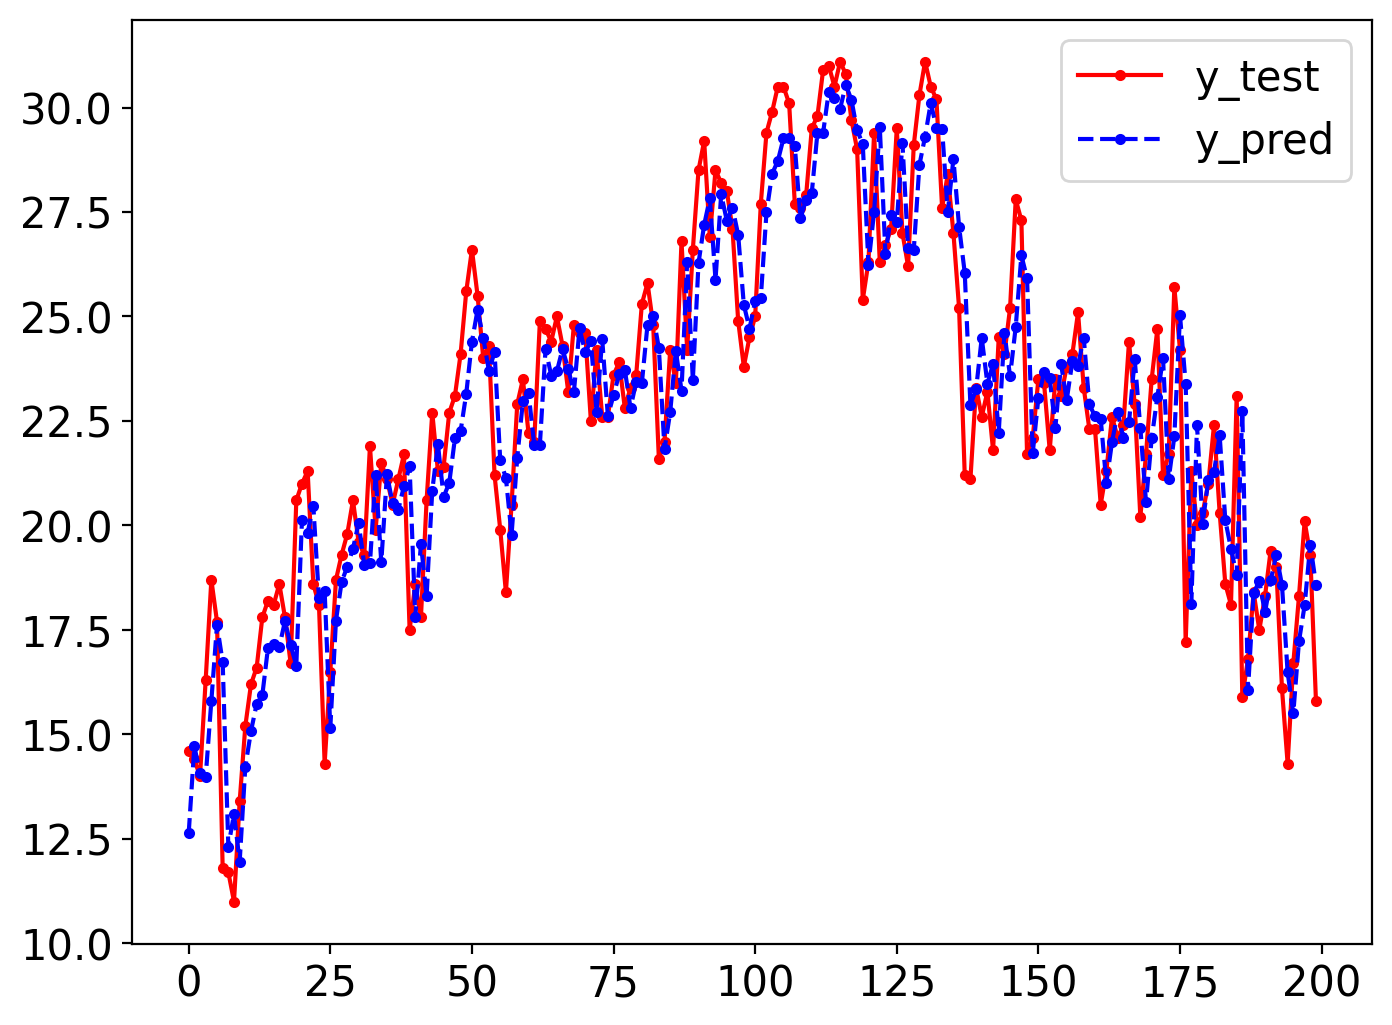

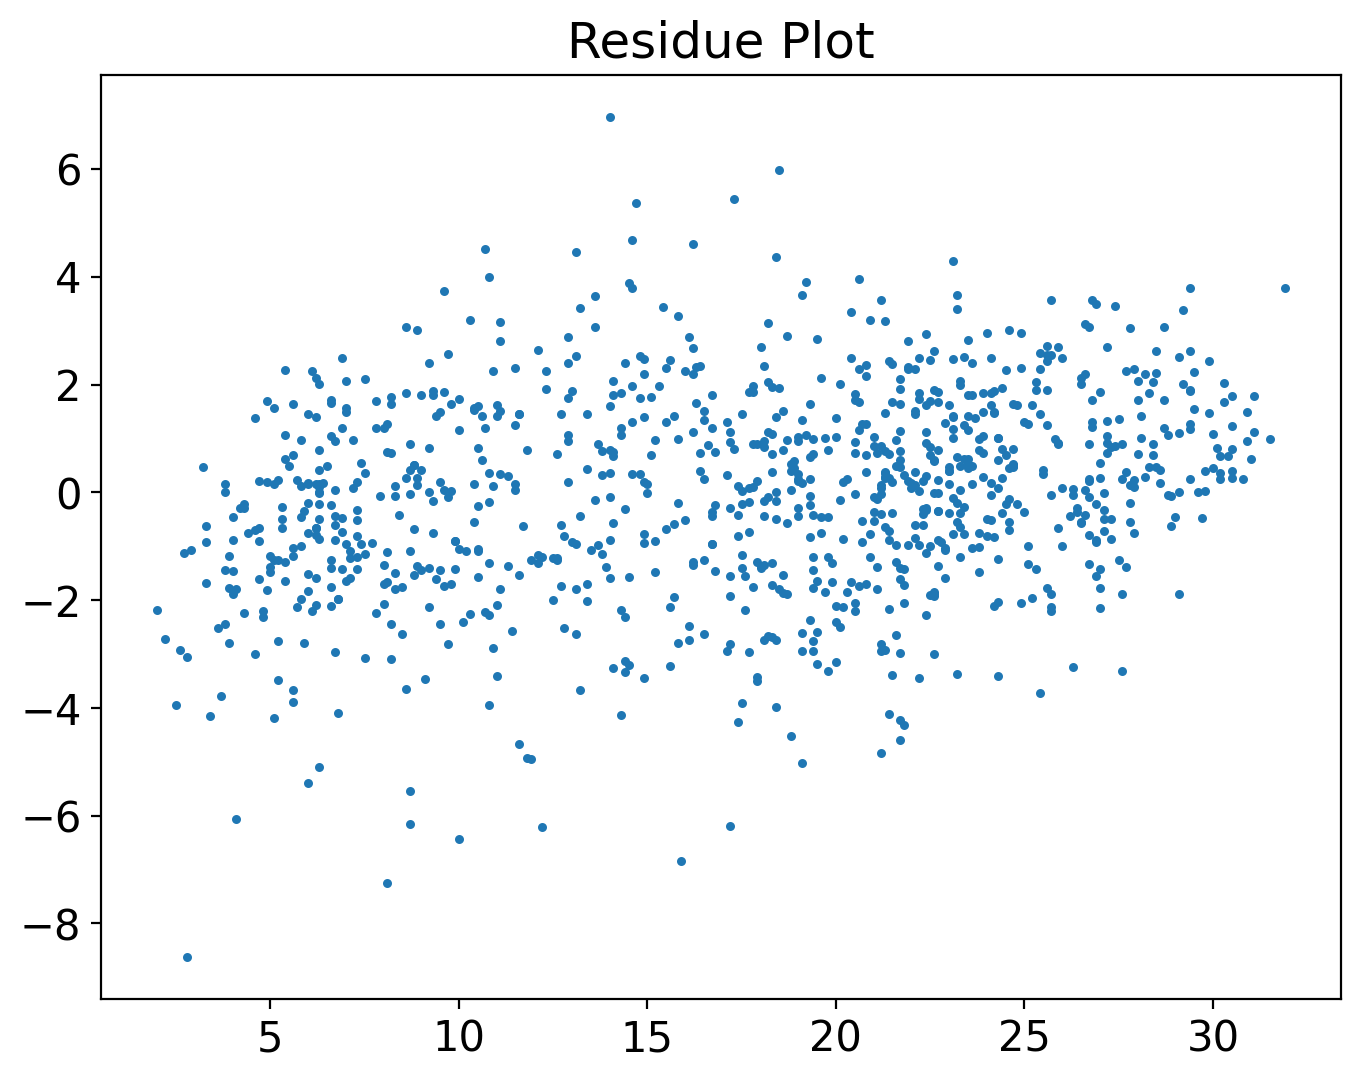

In [20]:
plot_reg_result(y_test, y_pred, 200)

## (연습) 선형 예측 모델에서 과거 5일 및 15일을 사용할 때 각각의 성능을 구하시오

In [ ]:
# (풀이)



## (연습) 선형 예측 모델에서 과거 몇 개를 예측에 사용하면 성능이 가장 좋은지 최적 값을 찾으시오

- 힌트 n_steps 값을 바꾸어 본다 (1 ~ 180 일)
- 가장 성능이 좋을 때의 회귀 성능을 확인하시오

In [42]:
# (풀이)
res = []
for n_steps in range(1,181):
  x_train, y_train = split_seq(train_data, n_steps)
  x_test, y_test = split_seq(test_data, n_steps)
  # model = LinearRegression()
  model.fit(x_train, y_train)
  res.append((n_steps, model.score(x_test, y_test).round(4))) # R2 값

In [43]:
res

[(1, 0.9279),
 (2, 0.9284),
 (3, 0.9318),
 (4, 0.933),
 (5, 0.9333),
 (6, 0.9345),
 (7, 0.9349),
 (8, 0.9356),
 (9, 0.9355),
 (10, 0.936),
 (11, 0.9361),
 (12, 0.9361),
 (13, 0.936),
 (14, 0.9362),
 (15, 0.9362),
 (16, 0.9363),
 (17, 0.9366),
 (18, 0.937),
 (19, 0.937),
 (20, 0.937),
 (21, 0.9371),
 (22, 0.9371),
 (23, 0.9372),
 (24, 0.9371),
 (25, 0.9371),
 (26, 0.9374),
 (27, 0.9373),
 (28, 0.9375),
 (29, 0.9376),
 (30, 0.9377),
 (31, 0.9378),
 (32, 0.9381),
 (33, 0.9382),
 (34, 0.9382),
 (35, 0.9389),
 (36, 0.9389),
 (37, 0.9389),
 (38, 0.9383),
 (39, 0.9389),
 (40, 0.9387),
 (41, 0.9387),
 (42, 0.9387),
 (43, 0.9388),
 (44, 0.9386),
 (45, 0.9385),
 (46, 0.9385),
 (47, 0.9386),
 (48, 0.9385),
 (49, 0.9385),
 (50, 0.9388),
 (51, 0.9386),
 (52, 0.9388),
 (53, 0.9388),
 (54, 0.9388),
 (55, 0.9388),
 (56, 0.9388),
 (57, 0.9388),
 (58, 0.9388),
 (59, 0.9387),
 (60, 0.9387),
 (61, 0.9384),
 (62, 0.9385),
 (63, 0.9386),
 (64, 0.9385),
 (65, 0.9388),
 (66, 0.939),
 (67, 0.9392),
 (68, 0.939

# 베이스라인 모델
- 간단히 만들 수 있는 모델로 나이브 모델이라고도 한다
- 최소한 이것보다는 성능이 개선된 모델을 만들어야 한다
- 종류
 - persistent 모델: 직전의 샘플 값으로 다음 값을 예측
 - 이동 평균 모델: 직전의 N개 샘플의 평균으로 예측 (최근 값의 비중을 크게 반영하는 지수형 가중 평균을 사용하기도 한다, ema:exponential moving average)
 - 직전 값들이 아니라 주기적인 일정 간격으로 샘플을 취하기도 한다

## persistent 모델

In [ ]:
# 현재 값 하나로 다음 값을 예측하는 경우
y_pred, y_test = split_seq(test_data, 1)

In [ ]:
y_pred[:5], y_test[:5]

(array([[15.2],
        [13.8],
        [15.3],
        [11.4],
        [ 9. ]]),
 array([13.8, 15.3, 11.4,  9. , 11.4]))

In [ ]:
show_reg_result(y_test, y_pred)

Max Error:  29.9
Mean Absolute Error:  8.695
Root Mean Squared Error:  2.051
R-Squared:  0.927


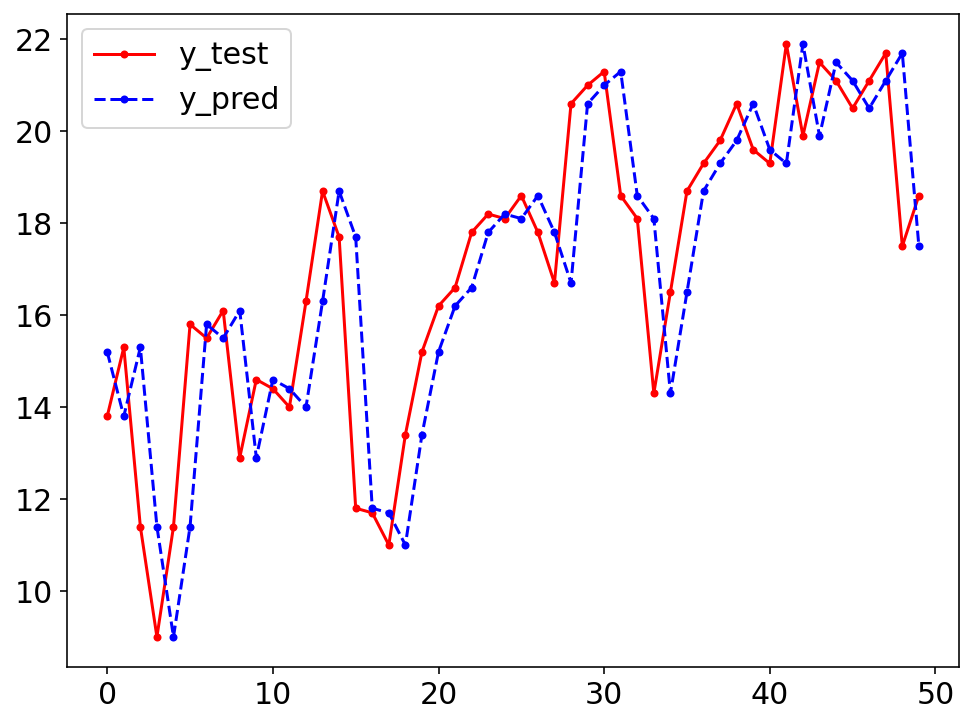

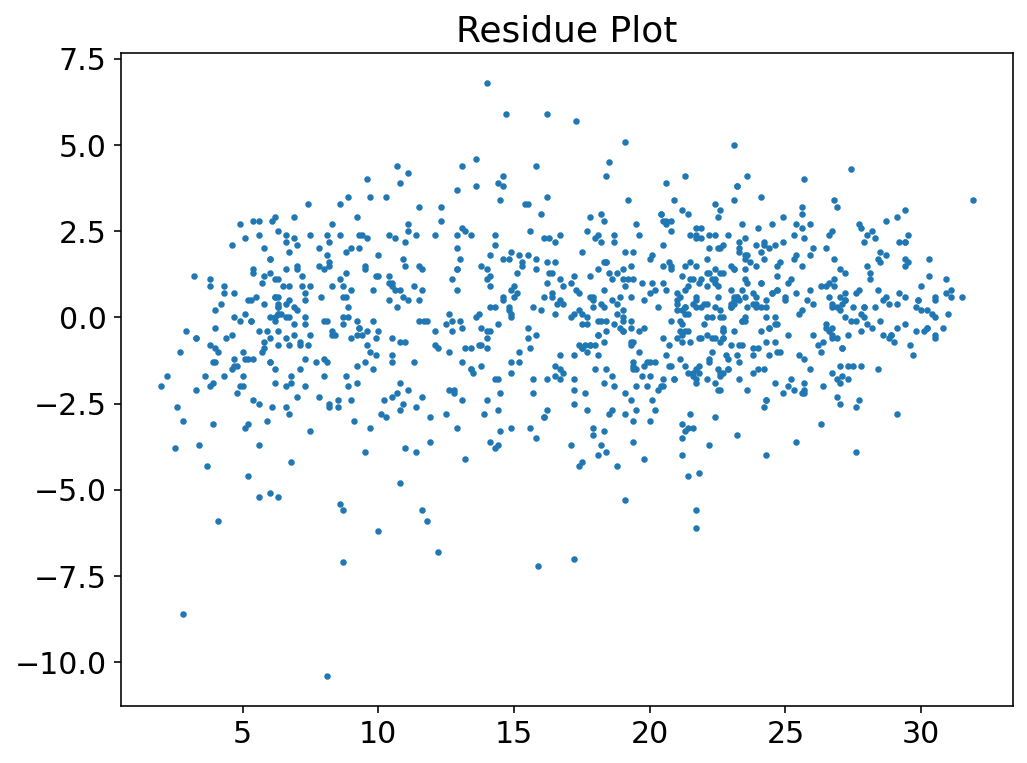

In [ ]:
plot_reg_result(y_test, y_pred)

## 과거의 평균치로 예측하는 경우

In [ ]:
# 입력 데이터의 평균치를 리턴하는 함수
# 행단위 평균을 구하기 위해서 axis=1 지정
def average_model(seq):
    return np.array(seq).mean(axis=1)

In [ ]:
# 동작 확인 (행별로 4개 데이터의 평균을 얻기)
z = np.arange(24).reshape(6,4)
print(z)
average_model(z)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]]


array([ 1.5,  5.5,  9.5, 13.5, 17.5, 21.5])

In [ ]:
# 과거 몇 개(N)의 평균을 사용할 때 성능이 가장 좋은지 확인
N = 20
result = []
for average in range(1,N+1):
    x_test, y_test = split_seq(test_data, average)
    y_pred = average_model(x_test)
    result.append((average, r2_score(y_test, y_pred).round(4)))
result

[(1, 0.9266),
 (2, 0.9166),
 (3, 0.9113),
 (4, 0.9074),
 (5, 0.9037),
 (6, 0.901),
 (7, 0.8991),
 (8, 0.8982),
 (9, 0.8971),
 (10, 0.896),
 (11, 0.8948),
 (12, 0.8932),
 (13, 0.8913),
 (14, 0.8897),
 (15, 0.888),
 (16, 0.8861),
 (17, 0.8841),
 (18, 0.8812),
 (19, 0.8778),
 (20, 0.8741)]

<AxesSubplot:xlabel='window'>

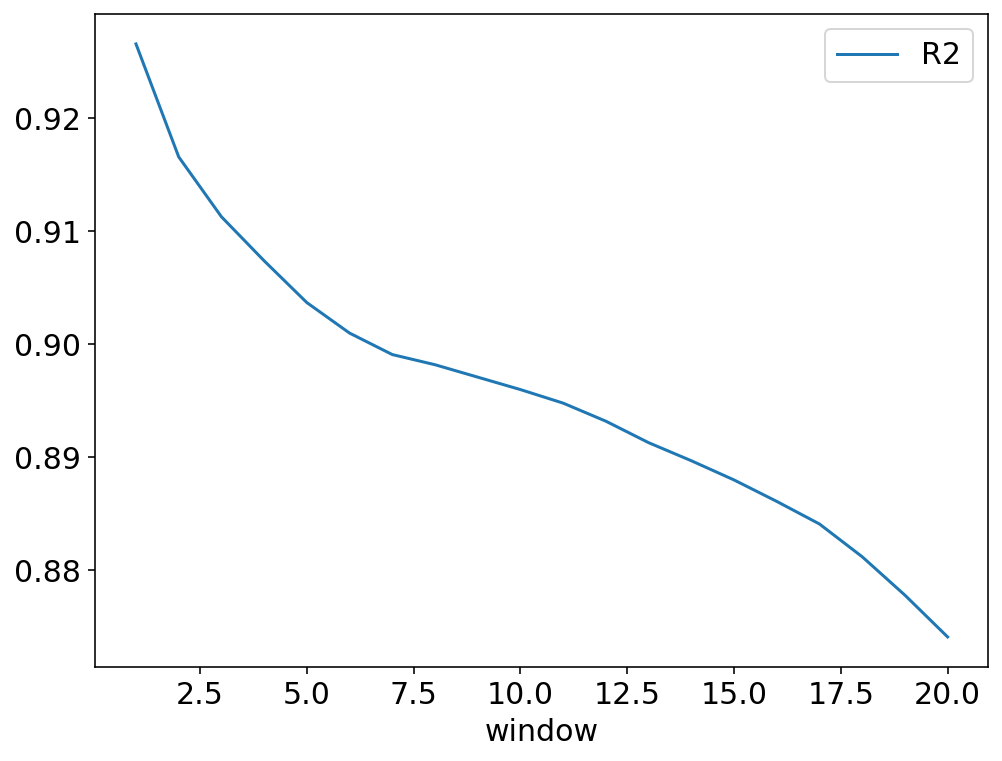

In [ ]:
df_result = pd.DataFrame(result, columns=['window','R2'])
df_result.set_index('window', drop=True).plot()

## (연습) 최적의 윈도우 값을 찾는 위의 예에서 결과를 리스트가 아니라 딕셔너리에 담아보시오

- 딕셔너리에 값을 담을 때는 key를 인자로 사용하고 값을 배정하면 된다
- 결과를 그래프로 그려보시오

In [ ]:
# (풀이)



# 에너지 사용 예측

## 데이터

- 한 가정의 시간단위 에너지 사용 데이터를 이용해 시계열 예측을 수행하겠다

In [51]:
power = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv",
                 parse_dates=['timestamp'])
power.set_index("timestamp", inplace=True)

print(power.shape)
power[:3]

(26304, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


In [52]:
power.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2012-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    26304 non-null  float64
 1   temp    26304 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


In [53]:
# 참조_년월일이 문자
power1 = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv")
# power.set_index("timestamp", inplace=True)

print(power1.shape)
power1[:3]

(26304, 3)


,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000


In [54]:
power1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  26304 non-null  object 
 1   load       26304 non-null  float64
 2   temp       26304 non-null  float64
dtypes: float64(2), object(1)
memory usage: 616.6+ KB


<Axes: xlabel='timestamp'>

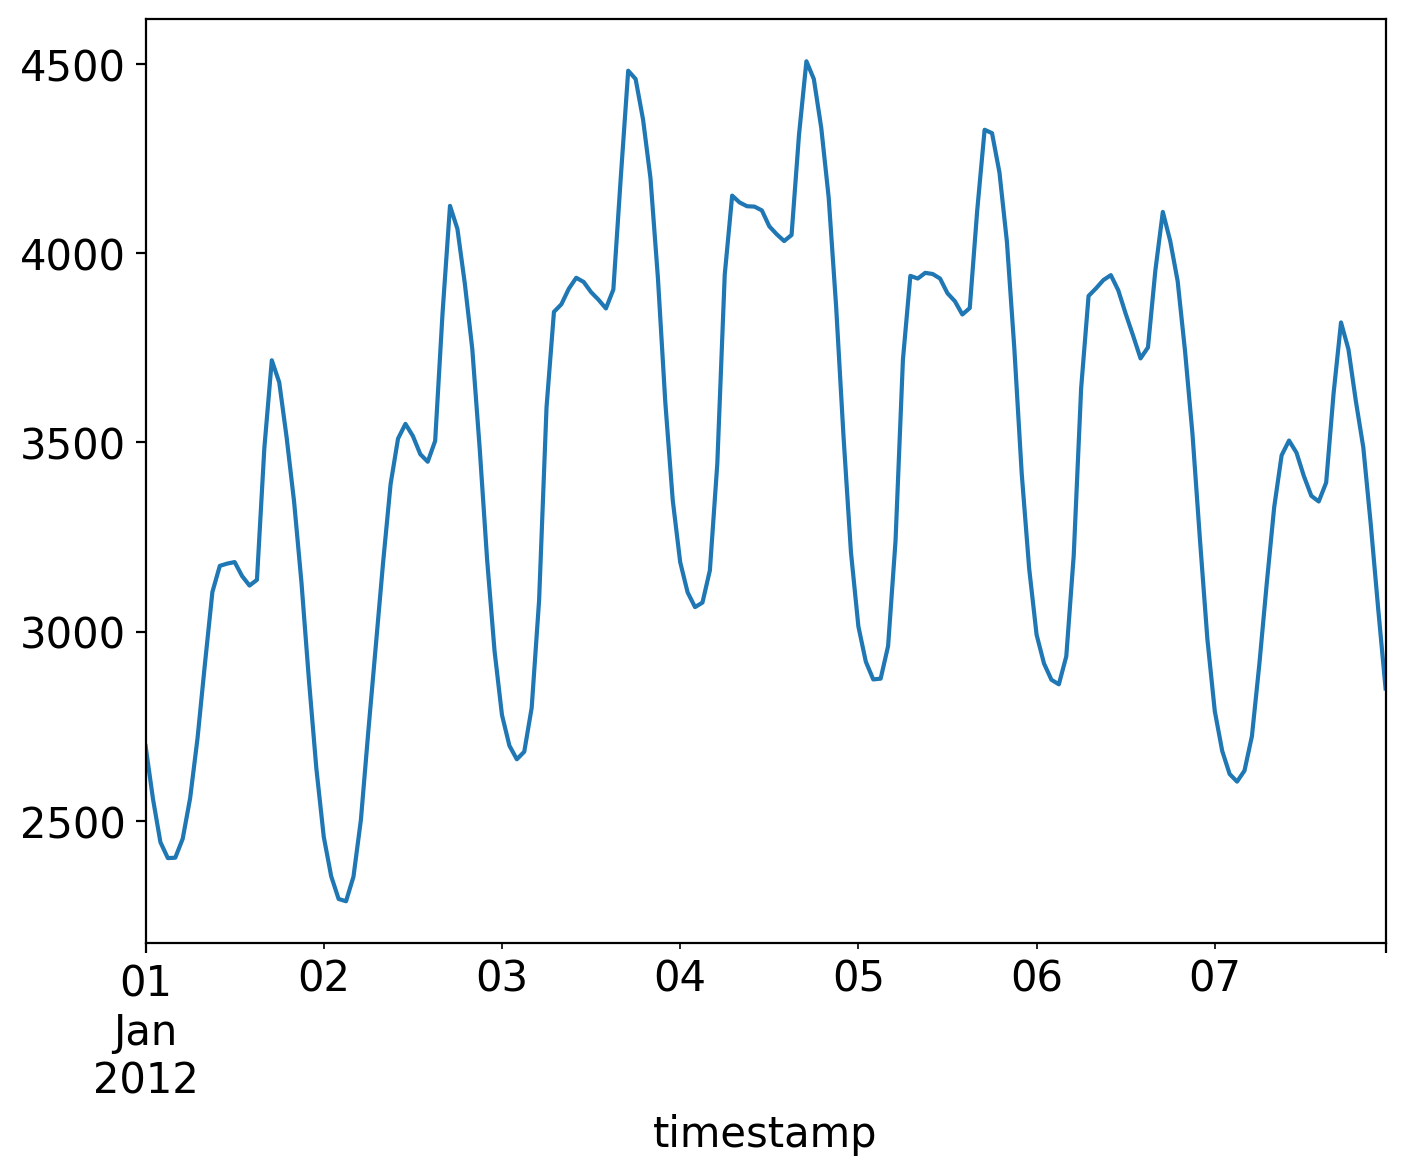

In [55]:
power.load[:24*7].plot()

- 하루 단위 데이터로 다운 샘플링 하는 방법
- 하루의 전력 사용량 합계를 사용하겠다

In [56]:
# 이틀은 2D, 3시간은 3h
df_down = power.resample('D').sum()
print(df_down.shape)
df_down[:3]

(1096, 2)


,load,temp
timestamp,,
2012-01-01,71562.0,906.333333
2012-01-02,76841.0,897.666667
2012-01-03,87887.0,418.333333


- 기온은 합이 아니라 평균을 사용하겠다.

In [ ]:
df_down['temp'] = power.temp.resample('D').mean()
df_down[:5]

,load,temp
timestamp,,
2012-01-01,71562.0,37.763889
2012-01-02,76841.0,37.402778
2012-01-03,87887.0,17.430556
2012-01-04,92168.0,13.111111
2012-01-05,88096.0,24.875000


## 단변수 시계열 예측 (load)

In [ ]:
y = df_down.load
train_data, test_data = train_test_split(y, shuffle=False)
len(y), len(train_data), len(test_data)

(1096, 822, 274)

### 선형 예측 모델

max R2:  0.797


Text(0.5, 1.0, 'R2 vs window size (Linear Model)')

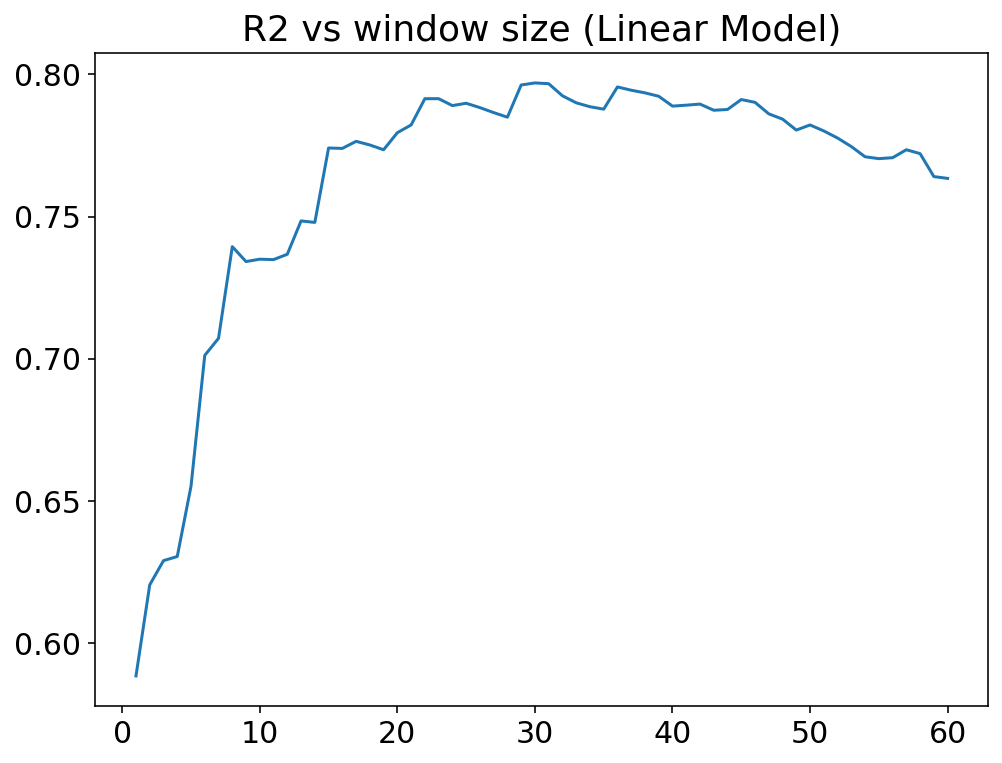

In [ ]:
N = 60
model = LinearRegression()
result = []

for n_steps in range(1,N+1):
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train)
    result.append((n_steps, model.score(x_test, y_test)))

result = np.array(result)
print("max R2: ", result[:,1].max().round(3))
plt.plot(result[:,0], result[:,1])
plt.title("R2 vs window size (Linear Model)")

- 최적의 윈도우 선택

In [ ]:
x_train, y_train = split_seq(train_data, 30)
x_test, y_test = split_seq(test_data, 30)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  14205.837
Mean Absolute Error:  2220.282
Root Mean Squared Error:  3031.463
R-Squared:  0.797


- 모델, 데이터, 윈도우 크기를 주면 시계열 분석을 수행하는 함수 정의

In [ ]:
def split_seq_fit(model, train_data, test_data, n_steps):
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train)
    return model.score(x_test, y_test)

### 랜덤 포레스트 모델을 사용하는 경우

max R2:  0.74


Text(0.5, 1.0, 'R2 vs window size(Random Forest)')

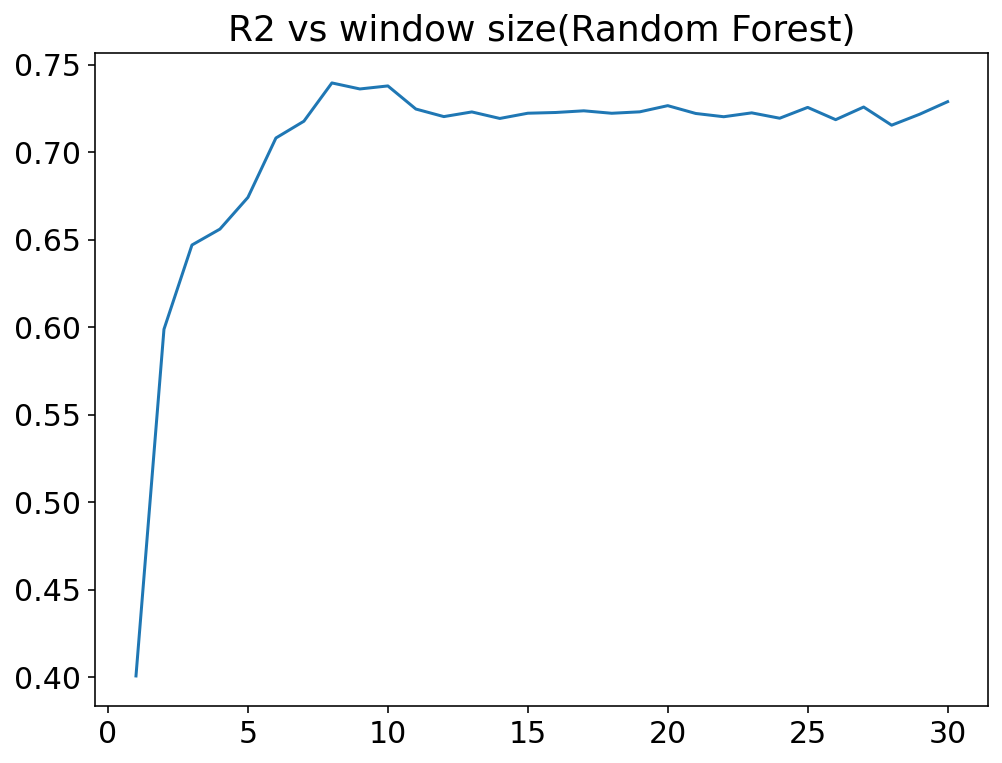

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
N = 30
result = []

for n_steps in range(1,N+1):
    r2 = split_seq_fit(rfr, train_data, test_data, n_steps)
    result.append((n_steps, r2))

result = np.array(result)
print("max R2: ", result[:,1].max().round(3))

plt.plot(result[:,0], result[:,1])
plt.title("R2 vs window size(Random Forest)")

### (연습) LightGBM 모델을 사용하고 윈도우 크기를 바꾸어 성능을 비교하시오

- lightgbm을 먼저 설치해야 한다 (!pip install lightgbm)
- 모델로 LGBMRegressor()를 사용한다

In [ ]:
# (풀이)



## 다중변수 예측

- 자신의 과거값을 예측에 사용하되 다양한 특성을 같이 사용하는 방법

### 특성 추가

- 과거 15일치 전력사용량과 5일간의 날씨를 입력으로 사용하는 경우
- 미래 3일간 전력사용량을 예측

In [ ]:
df_down[:17]

,load,temp
timestamp,,
2012-01-01,71562.0,37.763889
2012-01-02,76841.0,37.402778
2012-01-03,87887.0,17.430556
2012-01-04,92168.0,13.111111
2012-01-05,88096.0,24.875000
2012-01-06,85591.0,25.902778
2012-01-07,76869.0,31.652778
2012-01-08,77767.0,30.000000
2012-01-09,85818.0,25.277778


In [ ]:
df = df_down.copy()

df['load-1'] = df.load.shift(1)
df[:5]

,load,temp,load-1
timestamp,,,
2012-01-01,71562.0,37.763889,NaN
2012-01-02,76841.0,37.402778,71562.0
2012-01-03,87887.0,17.430556,76841.0
2012-01-04,92168.0,13.111111,87887.0
2012-01-05,88096.0,24.875000,92168.0


- 과거 15일간의 전력사용 데이터 커럼에 추가

In [ ]:
N_load = 5
for i in range (1,N_load + 1):
    df['load-'+str(i)]=df.load.shift(i)
df[:10]

,load,temp,load-1,load-2,load-3,load-4,load-5
timestamp,,,,,,,
2012-01-01,71562.0,37.763889,NaN,NaN,NaN,NaN,NaN
2012-01-02,76841.0,37.402778,71562.0,NaN,NaN,NaN,NaN
2012-01-03,87887.0,17.430556,76841.0,71562.0,NaN,NaN,NaN
2012-01-04,92168.0,13.111111,87887.0,76841.0,71562.0,NaN,NaN
2012-01-05,88096.0,24.875000,92168.0,87887.0,76841.0,71562.0,NaN
2012-01-06,85591.0,25.902778,88096.0,92168.0,87887.0,76841.0,71562.0
2012-01-07,76869.0,31.652778,85591.0,88096.0,92168.0,87887.0,76841.0
2012-01-08,77767.0,30.000000,76869.0,85591.0,88096.0,92168.0,87887.0
2012-01-09,85818.0,25.277778,77767.0,76869.0,85591.0,88096.0,92168.0


-  과거 5일의 날씨 데이터 추가

In [ ]:
N_temp = 5
for i in range (1,N_temp+1):
    df['temp-'+str(i)]=df.temp.shift(i)

In [ ]:
df

,load,temp,load-1,load-2,load-3,load-4,load-5,temp-1,temp-2,temp-3,temp-4,temp-5
timestamp,,,,,,,,,,,,
2012-01-01,71562.0,37.763889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02,76841.0,37.402778,71562.0,NaN,NaN,NaN,NaN,37.763889,NaN,NaN,NaN,NaN
2012-01-03,87887.0,17.430556,76841.0,71562.0,NaN,NaN,NaN,37.402778,37.763889,NaN,NaN,NaN
2012-01-04,92168.0,13.111111,87887.0,76841.0,71562.0,NaN,NaN,17.430556,37.402778,37.763889,NaN,NaN
2012-01-05,88096.0,24.875000,92168.0,87887.0,76841.0,71562.0,NaN,13.111111,17.430556,37.402778,37.763889,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,73845.0,38.666667,74155.0,69507.0,77368.0,83002.0,84443.0,41.569444,44.486111,39.027778,35.666667,31.041667
2014-12-28,74678.0,43.125000,73845.0,74155.0,69507.0,77368.0,83002.0,38.666667,41.569444,44.486111,39.027778,35.666667
2014-12-29,84486.0,30.305556,74678.0,73845.0,74155.0,69507.0,77368.0,43.125000,38.666667,41.569444,44.486111,39.027778


- 목적 변수 추가: 미래 3일까지 예측하려고 한다

In [ ]:
df['y+1'] = df.load.shift(-1)
df['y+2'] = df.load.shift(-2)
df['y+3'] = df.load.shift(-3)
df[:20]

,load,temp,load-1,load-2,load-3,load-4,load-5,temp-1,temp-2,temp-3,temp-4,temp-5,y+1,y+2,y+3
timestamp,,,,,,,,,,,,,,,
2012-01-01,71562.0,37.763889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76841.0,87887.0,92168.0
2012-01-02,76841.0,37.402778,71562.0,NaN,NaN,NaN,NaN,37.763889,NaN,NaN,NaN,NaN,87887.0,92168.0,88096.0
2012-01-03,87887.0,17.430556,76841.0,71562.0,NaN,NaN,NaN,37.402778,37.763889,NaN,NaN,NaN,92168.0,88096.0,85591.0
2012-01-04,92168.0,13.111111,87887.0,76841.0,71562.0,NaN,NaN,17.430556,37.402778,37.763889,NaN,NaN,88096.0,85591.0,76869.0
2012-01-05,88096.0,24.875000,92168.0,87887.0,76841.0,71562.0,NaN,13.111111,17.430556,37.402778,37.763889,NaN,85591.0,76869.0,77767.0
2012-01-06,85591.0,25.902778,88096.0,92168.0,87887.0,76841.0,71562.0,24.875000,13.111111,17.430556,37.402778,37.763889,76869.0,77767.0,85818.0
2012-01-07,76869.0,31.652778,85591.0,88096.0,92168.0,87887.0,76841.0,25.902778,24.875000,13.111111,17.430556,37.402778,77767.0,85818.0,85158.0
2012-01-08,77767.0,30.000000,76869.0,85591.0,88096.0,92168.0,87887.0,31.652778,25.902778,24.875000,13.111111,17.430556,85818.0,85158.0,85021.0
2012-01-09,85818.0,25.277778,77767.0,76869.0,85591.0,88096.0,92168.0,30.000000,31.652778,25.902778,24.875000,13.111111,85158.0,85021.0,84824.0


In [ ]:
df[-5:]

,load,temp,load-1,load-2,load-3,load-4,load-5,temp-1,temp-2,temp-3,temp-4,temp-5,y+1,y+2,y+3
timestamp,,,,,,,,,,,,,,,
2014-12-27,73845.0,38.666667,74155.0,69507.0,77368.0,83002.0,84443.0,41.569444,44.486111,39.027778,35.666667,31.041667,74678.0,84486.0,88810.0
2014-12-28,74678.0,43.125000,73845.0,74155.0,69507.0,77368.0,83002.0,38.666667,41.569444,44.486111,39.027778,35.666667,84486.0,88810.0,89246.0
2014-12-29,84486.0,30.305556,74678.0,73845.0,74155.0,69507.0,77368.0,43.125000,38.666667,41.569444,44.486111,39.027778,88810.0,89246.0,NaN
2014-12-30,88810.0,18.347222,84486.0,74678.0,73845.0,74155.0,69507.0,30.305556,43.125000,38.666667,41.569444,44.486111,89246.0,NaN,NaN
2014-12-31,89246.0,17.375000,88810.0,84486.0,74678.0,73845.0,74155.0,18.347222,30.305556,43.125000,38.666667,41.569444,NaN,NaN,NaN


- 결측치 제거
- 일부 데이터가 학습에 사용되지 못한다 (샘플수가 적을 때 주의)

In [ ]:
df = df.dropna()
print(df.shape)
df[:20]

(1088, 15)


,load,temp,load-1,load-2,load-3,load-4,load-5,temp-1,temp-2,temp-3,temp-4,temp-5,y+1,y+2,y+3
timestamp,,,,,,,,,,,,,,,
2012-01-06,85591.0,25.902778,88096.0,92168.0,87887.0,76841.0,71562.0,24.875000,13.111111,17.430556,37.402778,37.763889,76869.0,77767.0,85818.0
2012-01-07,76869.0,31.652778,85591.0,88096.0,92168.0,87887.0,76841.0,25.902778,24.875000,13.111111,17.430556,37.402778,77767.0,85818.0,85158.0
2012-01-08,77767.0,30.000000,76869.0,85591.0,88096.0,92168.0,87887.0,31.652778,25.902778,24.875000,13.111111,17.430556,85818.0,85158.0,85021.0
2012-01-09,85818.0,25.277778,77767.0,76869.0,85591.0,88096.0,92168.0,30.000000,31.652778,25.902778,24.875000,13.111111,85158.0,85021.0,84824.0
2012-01-10,85158.0,33.013889,85818.0,77767.0,76869.0,85591.0,88096.0,25.277778,30.000000,31.652778,25.902778,24.875000,85021.0,84824.0,83503.0
2012-01-11,85021.0,24.916667,85158.0,85818.0,77767.0,76869.0,85591.0,33.013889,25.277778,30.000000,31.652778,25.902778,84824.0,83503.0,84300.0
2012-01-12,84824.0,29.361111,85021.0,85158.0,85818.0,77767.0,76869.0,24.916667,33.013889,25.277778,30.000000,31.652778,83503.0,84300.0,88319.0
2012-01-13,83503.0,30.375000,84824.0,85021.0,85158.0,85818.0,77767.0,29.361111,24.916667,33.013889,25.277778,30.000000,84300.0,88319.0,91228.0
2012-01-14,84300.0,19.055556,83503.0,84824.0,85021.0,85158.0,85818.0,30.375000,29.361111,24.916667,33.013889,25.277778,88319.0,91228.0,83799.0


- 모든 특성을 사용하고 내일의 전력 사용량을 예측하는 경우

In [ ]:
X = df[df.columns.difference(['y+1', 'y+2', 'y+3'])]
y = df['y+1']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                shuffle=False, random_state=9)

In [ ]:
X_train[:5]

,load,load-1,load-2,load-3,load-4,load-5,temp,temp-1,temp-2,temp-3,temp-4,temp-5
timestamp,,,,,,,,,,,,
2012-01-06,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,25.902778,24.875000,13.111111,17.430556,37.402778,37.763889
2012-01-07,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,31.652778,25.902778,24.875000,13.111111,17.430556,37.402778
2012-01-08,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,30.000000,31.652778,25.902778,24.875000,13.111111,17.430556
2012-01-09,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,25.277778,30.000000,31.652778,25.902778,24.875000,13.111111
2012-01-10,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,33.013889,25.277778,30.000000,31.652778,25.902778,24.875000


In [ ]:
y[:5]

timestamp
2012-01-06    76869.0
2012-01-07    77767.0
2012-01-08    85818.0
2012-01-09    85158.0
2012-01-10    85021.0
Freq: D, Name: y+1, dtype: float64

In [ ]:
lin = LinearRegression()
lin.fit(X_train, y_train)
lin.score(X_test, y_test).round(4)

0.6955

In [ ]:
y_pred = lin.predict(X_test)
show_reg_result(y_test, y_pred)

Max Error:  15806.02
Mean Absolute Error:  2685.421
Root Mean Squared Error:  3584.568
R-Squared:  0.696


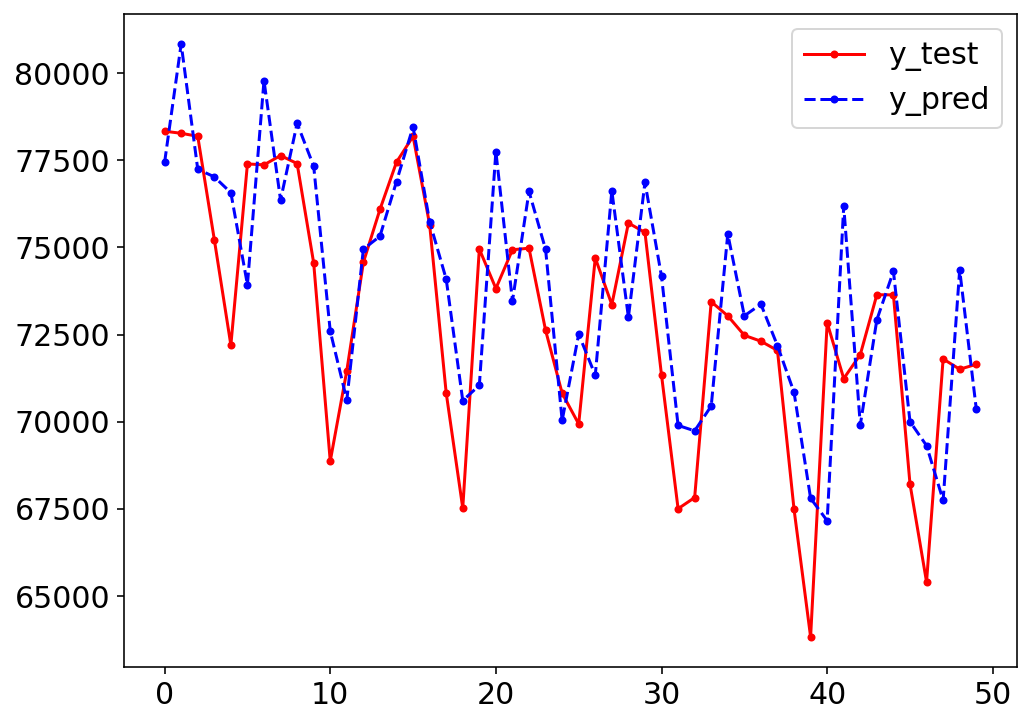

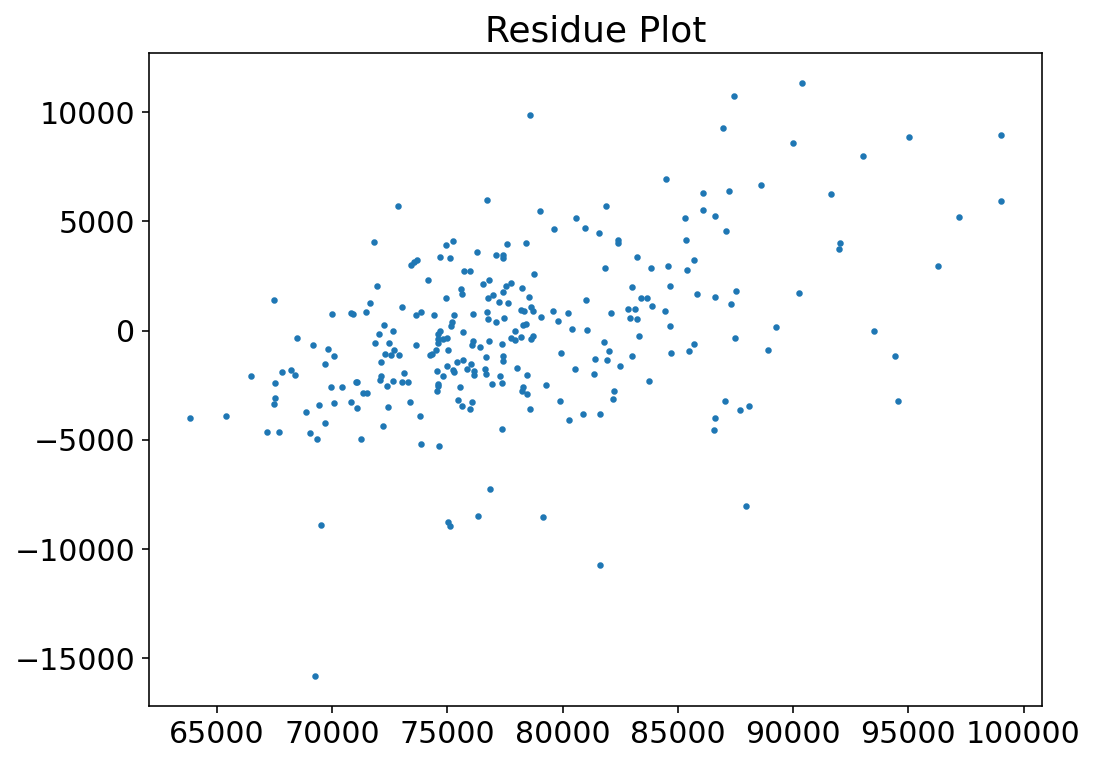

In [ ]:
plot_reg_result(y_test, y_pred)

- 모델과 데이터를 주고 학습 수행후 성능을 평가하는 함수
- 디폴트로 shuffle=False 로 설정함 (시계열 데이터 이므로 과거 데이터로만 학습)

In [ ]:
def model_run(model, X, y, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                shuffle=shuffle, random_state=9)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test).round(4)

- 동작 확인

In [ ]:
y = df['y+1']
model_run(lin, X, y, shuffle=False)

0.6955

In [ ]:
y = df['y+3']
model_run(lin, X, y, shuffle=False)

0.4572

### 선형, 랜덤포레스트, 부스팅 비교

In [ ]:
rfr = RandomForestRegressor()
lgbm_r = LGBMRegressor()

res = []
for model in [lin, rfr, lgbm_r]:
    for i in range(1,4):
        y = df['y+'+str(i)]
        r2 = model_run(model, X, y, shuffle=False)
        res.append((model, i, r2))
res

[(LinearRegression(), 1, 0.6955),
 (LinearRegression(), 2, 0.5021),
 (LinearRegression(), 3, 0.4572),
 (RandomForestRegressor(), 1, 0.7418),
 (RandomForestRegressor(), 2, 0.5665),
 (RandomForestRegressor(), 3, 0.4706),
 (LGBMRegressor(), 1, 0.7166),
 (LGBMRegressor(), 2, 0.4969),
 (LGBMRegressor(), 3, 0.3163)]

### 랜덤 포레스트 다중 예측
- 랜덤 포레스트는 한번에 여러개의 y 값을 예측하는 모델을 지원한다
- 아래는 y에 3개의 값을 예측하도록 했다

In [ ]:
y = df[['y+1', 'y+2', 'y+3']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        shuffle=False, random_state=9)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
r2_score(y_test, y_pred, multioutput='raw_values')

array([0.72037146, 0.58192409, 0.44804994])

## 기타 특성 추가
- 이동평균, 이동분산, 최대-최소 차이, 평활화(ewma: Exponentially-weighted moving average) 등 특성을 추가할 수 있다

In [ ]:
# 과거 5일간의 평균치를 컬럼에 추가
X2= X.copy()
X2["5-mean"] = X2.load.rolling(5,min_periods=1).mean()
X2[:5]

,load,load-1,load-2,load-3,load-4,load-5,temp,temp-1,temp-2,temp-3,temp-4,temp-5,5-mean
timestamp,,,,,,,,,,,,,
2012-01-06,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,25.902778,24.875000,13.111111,17.430556,37.402778,37.763889,85591.000000
2012-01-07,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,31.652778,25.902778,24.875000,13.111111,17.430556,37.402778,81230.000000
2012-01-08,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,30.000000,31.652778,25.902778,24.875000,13.111111,17.430556,80075.666667
2012-01-09,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,25.277778,30.000000,31.652778,25.902778,24.875000,13.111111,81511.250000
2012-01-10,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,33.013889,25.277778,30.000000,31.652778,25.902778,24.875000,82240.600000


- 다양한 특성 추가 예시
- ema에 지수형 가중값을 구한다
- min_periods=1 의 의미는 필요한 갯수가 되지 않더라도, 한개라도 평균 등을 계산하라는 뜻임 (초기 값들을 버리지 않기 위함)

In [ ]:
X2["20-mean"] = X2.load.rolling(20,min_periods=1).mean()
X2["10-std"] = X2.load.rolling(10, min_periods=1).std().fillna(0)
X2['5EWMA'] = X2.load.ewm(span=5).mean()
X2["5-max"] = X2.load.rolling(5, min_periods=1).max()
X2["5-min"] = X2.load.rolling(5, min_periods=1).min()
X2["5-peak-difference"] = X2.load.rolling(5, min_periods=1).max()-X2.load.rolling(5, min_periods=1).min()
X2[:3]

,load,load-1,load-2,load-3,load-4,load-5,temp,temp-1,temp-2,temp-3,temp-4,temp-5,5-mean,20-mean,10-std,5EWMA,5-max,5-min,5-peak-difference
timestamp,,,,,,,,,,,,,,,,,,,
2012-01-06,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,25.902778,24.875000,13.111111,17.430556,37.402778,37.763889,85591.000000,85591.000000,0.000000,85591.000000,85591.0,85591.0,0.0
2012-01-07,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,31.652778,25.902778,24.875000,13.111111,17.430556,37.402778,81230.000000,81230.000000,6167.385346,80357.800000,85591.0,76869.0,8722.0
2012-01-08,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,30.000000,31.652778,25.902778,24.875000,13.111111,17.430556,80075.666667,80075.666667,4797.476142,79130.578947,85591.0,76869.0,8722.0


In [ ]:
# X2를 사용하는 경우의 성능 비교 (아래에서 X2를 사용함)
res = []
for model in [lin, rfr, lgbm_r]:
    for i in range(1,4):
        y = df['y+'+str(i)]
        r2 = model_run(model, X2, y, shuffle=False)
        res.append((model, i, r2))
res

[(LinearRegression(), 1, 0.7011),
 (LinearRegression(), 2, 0.5213),
 (LinearRegression(), 3, 0.4473),
 (RandomForestRegressor(), 1, 0.7281),
 (RandomForestRegressor(), 2, 0.5439),
 (RandomForestRegressor(), 3, 0.433),
 (LGBMRegressor(), 1, 0.703),
 (LGBMRegressor(), 2, 0.5223),
 (LGBMRegressor(), 3, 0.3844)]

# 정답

## (연습) 윈도우가 7일 경우의 split_seq()를 수행해보시오

In [ ]:
sequence = [1,2,3,4,5,6,7,8,9,10,11,12,13]
split_seq(sequence, 5)

(array([[ 1,  2,  3,  4,  5],
        [ 2,  3,  4,  5,  6],
        [ 3,  4,  5,  6,  7],
        [ 4,  5,  6,  7,  8],
        [ 5,  6,  7,  8,  9],
        [ 6,  7,  8,  9, 10],
        [ 7,  8,  9, 10, 11],
        [ 8,  9, 10, 11, 12]]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13]))

## (연습) 선형 예측 모델에서 과거 5일 및 15일을 사용할 때 각각의 성능을 구하시오

In [ ]:
x_train, y_train = split_seq(train_data, 5)
x_test, y_test = split_seq(test_data, 5)
lin.fit(x_train, y_train)
lin.score(x_test, y_test)

0.6552295315279905

In [ ]:
x_train, y_train = split_seq(train_data, 15)
x_test, y_test = split_seq(test_data, 15)
lin.fit(x_train, y_train)
lin.score(x_test, y_test)

0.7741042562255631

## (연습) 선형 예측 모델에서 과거 몇 개를 예측에 사용하면 성능이 가장 좋은지 최적 값을 찾으시오

- 힌트 n_steps 값을 바꾸어 본다 (1 ~ 180 일)
- 가장 성능이 좋을 때의 회귀 성능을 확인하시오

In [ ]:
N = 180
result = []

for n_steps in range(1,N+1):
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    lin.fit(x_train, y_train)
    result.append((n_steps, lin.score(x_test, y_test)))

result[:10]

[(1, 0.5885693266332445),
 (2, 0.6205826540620332),
 (3, 0.6290923416158377),
 (4, 0.6305398828871488),
 (5, 0.6552295315279905),
 (6, 0.701232510790563),
 (7, 0.7072193052186136),
 (8, 0.7394399841135607),
 (9, 0.7341958675264326),
 (10, 0.7350308556968949)]

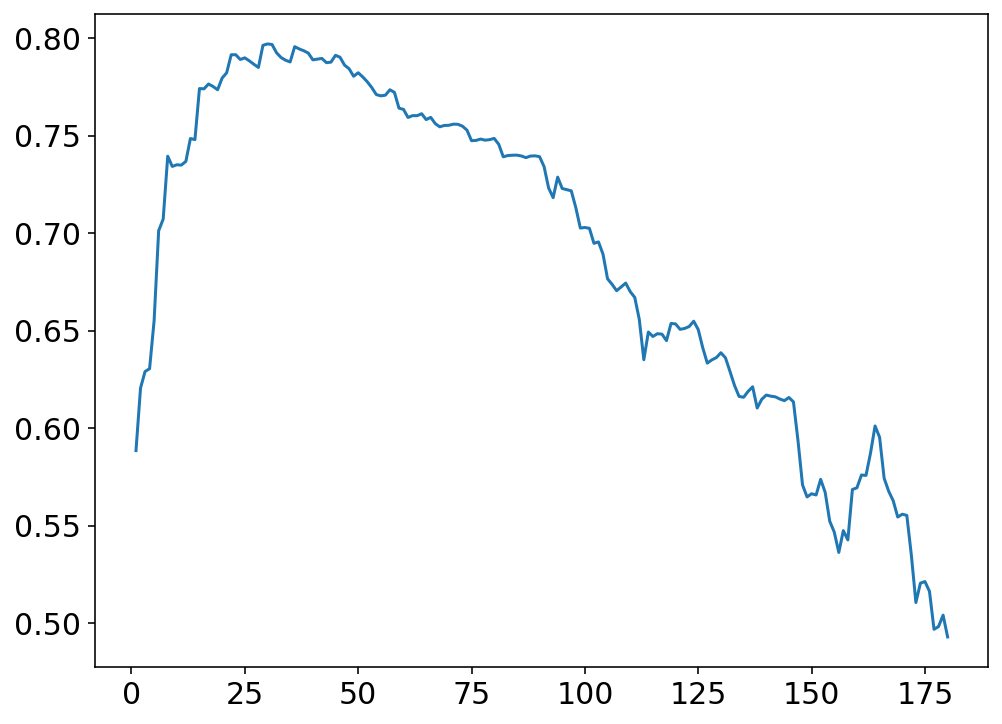

In [ ]:
result = np.array(result)
plt.plot(result[:,0], result[:,1])

In [ ]:
x_train, y_train = split_seq(train_data, 30)
x_test, y_test = split_seq(test_data, 30)
lin.fit(x_train, y_train)
y_pred = lin.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  14205.837
Mean Absolute Error:  2220.282
Root Mean Squared Error:  3031.463
R-Squared:  0.797


## (연습) 최적의 윈도우 값을 찾는 위의 예에서 결과를 리스트가 아니라 딕셔너리에 담아보시오

- 딕셔너리에 값을 담을 때는 key를 인자로 사용하고 값을 배정하면 된다
- 결과를 그래프로 그려보시오

In [ ]:
# 리스트가 아니라 딕서너리에 결과를 담는 방법
result = {}
N = 20
for i in range(1,N+1):
    n_steps=i
    x_test, y_test = split_seq(test_data, n_steps)
    y_pred = average_model(x_test)
    result[i]= r2_score(y_test, y_pred).round(4)

In [ ]:
result

{1: 0.5431,
 2: 0.3591,
 3: 0.2512,
 4: 0.2186,
 5: 0.2534,
 6: 0.3374,
 7: 0.4225,
 8: 0.4433,
 9: 0.4144,
 10: 0.3698,
 11: 0.3373,
 12: 0.3303,
 13: 0.3536,
 14: 0.3896,
 15: 0.3986,
 16: 0.379,
 17: 0.3454,
 18: 0.3159,
 19: 0.3025,
 20: 0.3103}

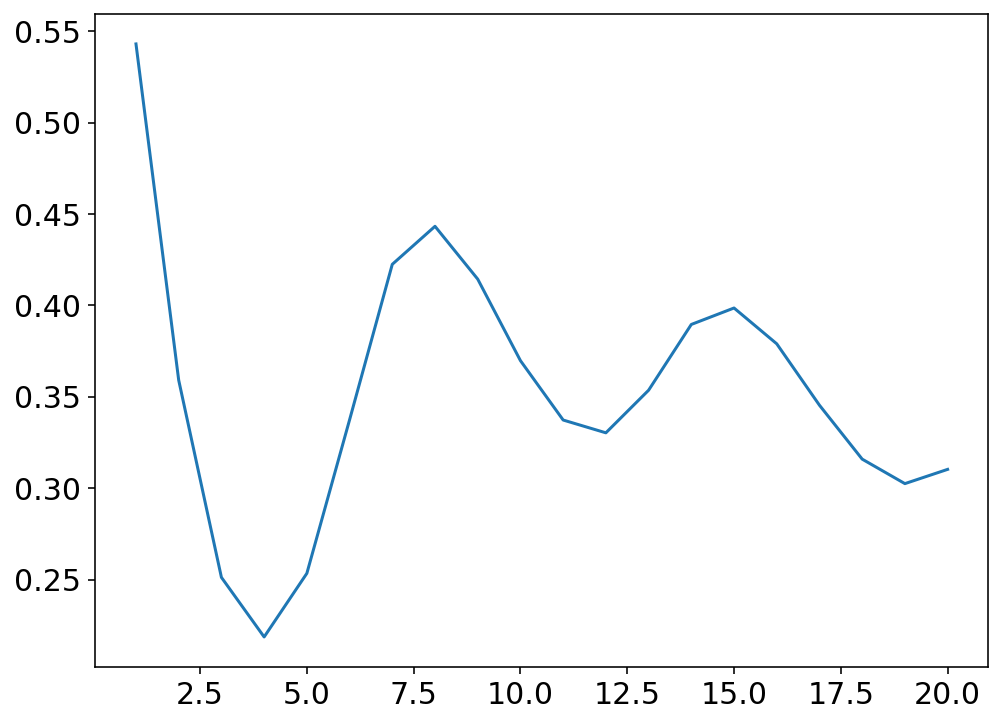

In [ ]:
plt.plot(result.keys(),result.values())

In [ ]:
# 최대값을 들어있는 항목의 키 찾기
# 최소값 찾는 함수는 min()
max(result, key=result.get)

1

## (연습) LightGBM 모델을 사용하고 윈도우 크기를 바꾸어 성능을 비교하시오

- lightgbm을 먼저 설치해야 한다 (!pip install lightgbm)
- 모델로 LGBMRegressor()를 사용한다

max R2:  0.735


Text(0.5, 1.0, 'R2 vs window size(LightGBM)')

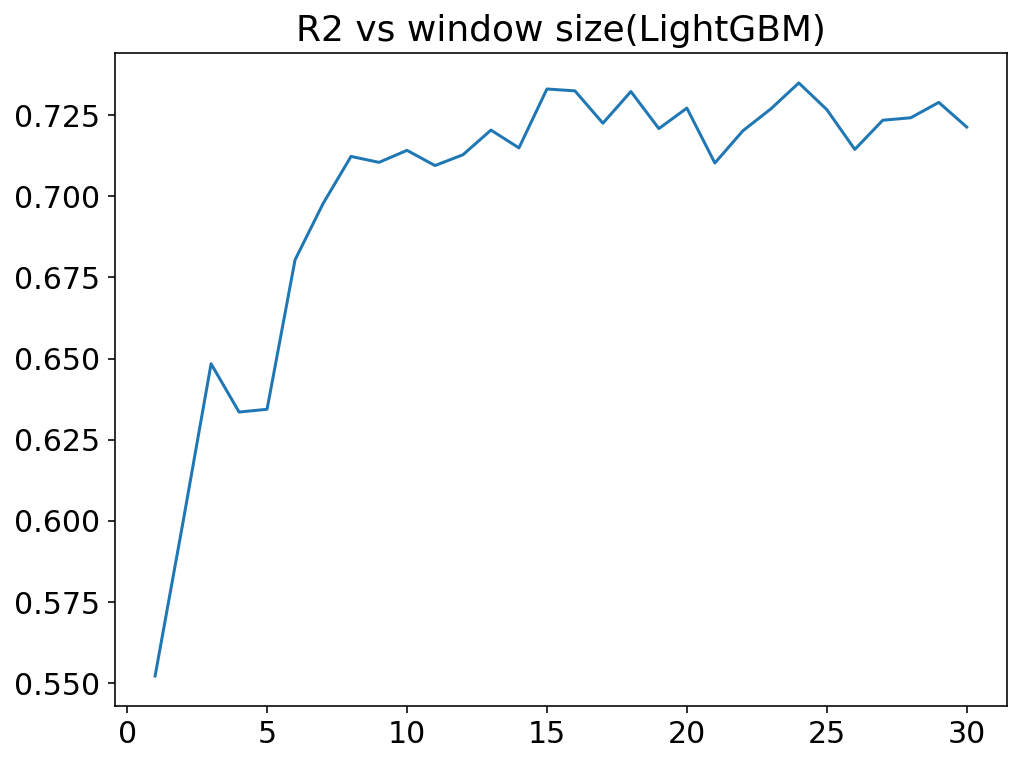

In [ ]:
lgbm_r = LGBMRegressor()
N = 30
result = []

for n_steps in range(1,N+1):
    r2 = split_seq_fit(lgbm_r, train_data, test_data, n_steps)
    result.append((n_steps, r2))

result = np.array(result)
print("max R2: ", result[:,1].max().round(3))

plt.plot(result[:,0], result[:,1])
plt.title("R2 vs window size(LightGBM)")